In [ ]:
# veri işleme, modelleme, doğrulama ve performans değerlendirme adımları için gerekli kütüphaneler projeye dahil edilir.
!pip install xgboost scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve)
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# HIGGS veri setinin ilk 100.000 satırını okur
# Veride başlık (kolon ismi) olmadığı için header=None olarak ayarlanır
df = pd.read_csv('/content/drive/MyDrive/HIGGS/HIGGS.csv', nrows=100000, header=None)

# Özellik sütunlarını (1. sütundan itibaren) giriş değişkenleri olarak tanımlar
X = df.iloc[:, 1:]

# İlk sütunu (0. indeks) hedef değişken (label) olarak alır ve tamsayı tipine dönüştürür
y = df.iloc[:, 0].astype(int)


Mounted at /content/drive


In [ ]:

# Aykırı değerleri IQR (Interquartile Range - Çeyrekler Arası Menzil) yöntemiyle kaldıran fonksiyon
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)   # 1. çeyrek (25. yüzdelik dilim)
    Q3 = df.quantile(0.75)   # 3. çeyrek (75. yüzdelik dilim)
    IQR = Q3 - Q1            # IQR: Çeyrekler arası açıklık
    # IQR'a göre alt ve üst sınırların dışında kalan (aykırı) satırlar filtrelenir
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Bağımsız değişkenlerden aykırı değerlerin temizlenmiş hali
X_clean = remove_outliers_iqr(X)

# Aykırı değerleri temizlenen veri kümesinde aynı indekslerle hedef değişkenin (y) güncellenmesi
y_clean = y[X_clean.index]

# StandardScaler tanımlanır (verileri ortalaması 0, standart sapması 1 olacak şekilde ölçekler)
scaler = StandardScaler()

# Aykırı değerlerden temizlenmiş veri kümesine standart ölçekleme uygulanır
X_scaled = scaler.fit_transform(X_clean)




In [ ]:

# Frequency / sınıfa göre ortalama özellik analizi
from sklearn.preprocessing import StandardScaler



# Frequency analizini bu noktada yap:
feature_names = [f"Feature_{i}" for i in range(X_scaled.shape[1])]
X_df = pd.DataFrame(X_scaled, columns=feature_names)
X_df["Class"] = y_clean.values

# Her sınıf için ortalama değerleri hesapla
class_feature_freq = X_df.groupby("Class").mean().T

In [ ]:
def evaluate_model(name, model, param_grid, X, y, feature_k_values, outer_cv, inner_cv):
    # Tüm dış katman testlerinin tahmin ve gerçek etiketlerini tutmak için listeler oluşturulur
    all_y_true = []
    all_y_pred = []
    all_y_prob = []  # ROC eğrisi ve AUC skoru için tahmin olasılıkları veya skorları
    scores = []      # Her outer fold’un AUC skorunu tutar

    best_k_overall = None           # En iyi k değeri (özellik sayısı)
    best_params_overall = None      # En iyi hiperparametreler

    # Dış çapraz doğrulama döngüsü (outer loop)
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

        best_auc = 0
        best_model = None

        # Farklı k (özellik sayısı) değerleri denenir
        for k in feature_k_values:
            pipe = Pipeline([
                ('select', SelectKBest(score_func=f_classif, k=k)),
                ('clf', model)
            ])

            # Hiperparametreler için iç çapraz doğrulama ile GridSearch yapılır
            grid = GridSearchCV(pipe, param_grid=param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
            grid.fit(X_train_outer, y_train_outer)

            # En iyi AUC skoru güncellenir
            if grid.best_score_ > best_auc:
                best_auc = grid.best_score_
                best_k_overall = k
                best_model = grid.best_estimator_
                best_params_overall = grid.best_params_

        if best_model is None:
            continue  # Eğer model seçilemezse fold atlanır

        # En iyi modeli yeniden eğit ve test verisinde tahmin yap
        best_model.fit(X_train_outer, y_train_outer)
        y_pred = best_model.predict(X_test_outer)

        # predict_proba varsa onu, yoksa decision_function'ı kullan
        if hasattr(best_model, "predict_proba"):
            y_scores = best_model.predict_proba(X_test_outer)[:, 1]
        else:
            y_scores = best_model.decision_function(X_test_outer)

        # Değerler biriktirilir
        all_y_true.extend(y_test_outer)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_scores)
        scores.append(roc_auc_score(y_test_outer, y_scores))

    # Modelin genel metrikleri hesaplanır
    acc = accuracy_score(all_y_true, all_y_pred)
    prec = precision_score(all_y_true, all_y_pred)
    rec = recall_score(all_y_true, all_y_pred)
    f1 = f1_score(all_y_true, all_y_pred)
    auc = roc_auc_score(all_y_true, all_y_prob)
    cm = confusion_matrix(all_y_true, all_y_pred)

    # Özet metrik çıktısı
    print(f"\n✅ {name} Sonuçları:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Confusion Matrix görselleştirme
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Purples')
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)
    plt.show()

    # ROC Eğrisi çizimi
    fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Sonuçları sözlük olarak döndür
    return {
        "Model": name,
        "Best k": best_k_overall,
        "Best Params": best_params_overall,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc,
        "Mean Test ROC-AUC": np.mean(scores),
        "Std": np.std(scores)
    }




In [ ]:
# Dış çapraz doğrulama (outer cross-validation) için 5 katlı StratifiedKFold tanımlanır
# Amaç: Modelin genel başarımını değerlendirmek (her model fold'lar arasında test edilir)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# İç çapraz doğrulama (inner cross-validation) için 3 katlı StratifiedKFold tanımlanır
# Amaç: GridSearchCV içinde en iyi hiperparametreleri ve en iyi k değerini seçmek
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Özellik seçimi (feature selection) için denenecek farklı k (özellik sayısı) değerleri belirlenir
# SelectKBest algoritması, bu listedeki her k değeri için en iyi k özelliği seçerek test yapacaktır
feature_k_values = [10, 15, 20]



✅ MLP Sonuçları:
Accuracy: 0.7124, Precision: 0.7297, Recall: 0.7472, F1: 0.7384, AUC: 0.7846


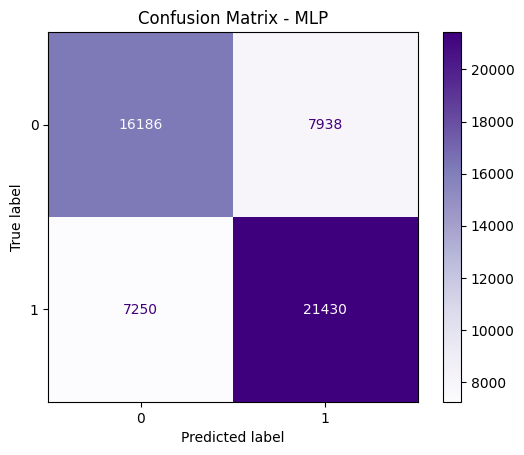

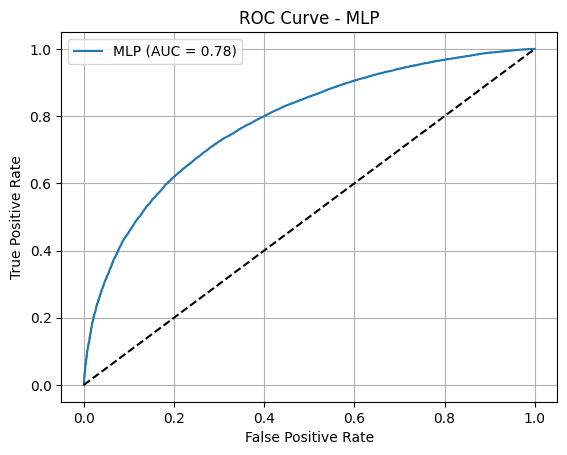

In [ ]:
mlp_result = evaluate_model(  # MLP modelini evaluate_model fonksiyonu ile değerlendir ve sonucu mlp_result değişkenine ata
    "MLP",  # Model adı (grafik ve çıktı etiketlerinde kullanılacak)

    MLPClassifier(max_iter=200),  # Maksimum 200 iterasyonla eğitim yapan çok katmanlı yapay sinir ağı modeli (MLPClassifier)

    {  # Hiperparametre arama alanı (GridSearch tarafından denenecek parametreler)
        'clf__hidden_layer_sizes': [(50,)],  # Gizli katman olarak sadece 50 nöron içeren tek katmanlı yapı denenecek
        'clf__activation': ['relu']          # Aktivasyon fonksiyonu olarak yalnızca ReLU (Rectified Linear Unit) kullanılacak
    },

    X_scaled,  # Özellikler: Aykırı değerlerden temizlenmiş ve StandardScaler ile ölçeklenmiş giriş verisi
    y_clean,   # Etiketler: Temizlenmiş hedef sınıf verisi

    feature_k_values,  # Özellik seçimi için denenmek üzere belirlenen k değerleri listesi (örneğin: [10, 15, 20])

    outer_cv,  # Dış çapraz doğrulama stratejisi (modelin genel başarımını test eder)
    inner_cv   # İç çapraz doğrulama stratejisi (GridSearch ile en iyi parametre ve özellik sayısını bulur)
)



✅ XGBoost Sonuçları:
Accuracy: 0.7138, Precision: 0.7334, Recall: 0.7431, F1: 0.7382, AUC: 0.7862


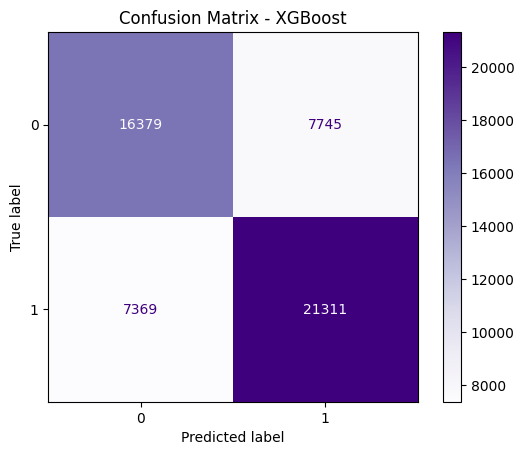

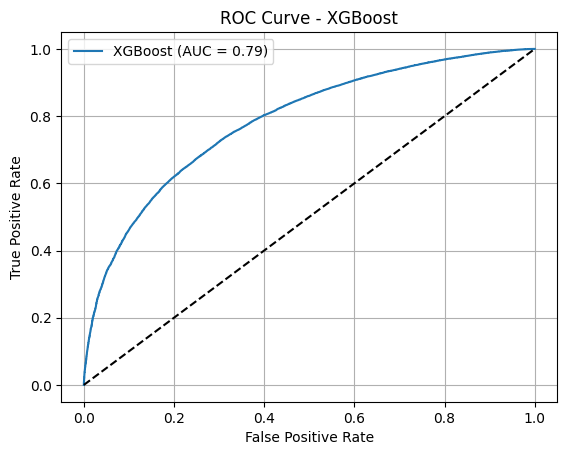

In [ ]:
xgboost_result = evaluate_model(  # XGBoost modelini değerlendirme fonksiyonuna gönder
    "XGBoost",  # Model adı

    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),  # XGBoost sınıflandırıcısı, logloss metrikli

    {
        'clf__n_estimators': [100],         # 100 ağaç kullanılacak
        'clf__max_depth': [3],              # Maksimum ağaç derinliği: 3
        'clf__learning_rate': [0.1]         # Öğrenme oranı: 0.1
    },

    X_scaled,  # Giriş verisi
    y_clean,   # Etiketler

    feature_k_values,  # Özellik seçimi için alternatif k değerleri

    outer_cv,  # 5 katlı test doğrulama
    inner_cv   # 3 katlı parametre arama
)



✅ SVM Sonuçları:
Accuracy: 0.6505, Precision: 0.6456, Recall: 0.7903, F1: 0.7106, AUC: 0.6868


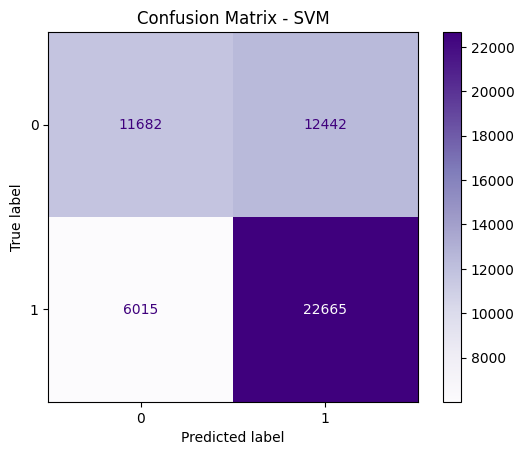

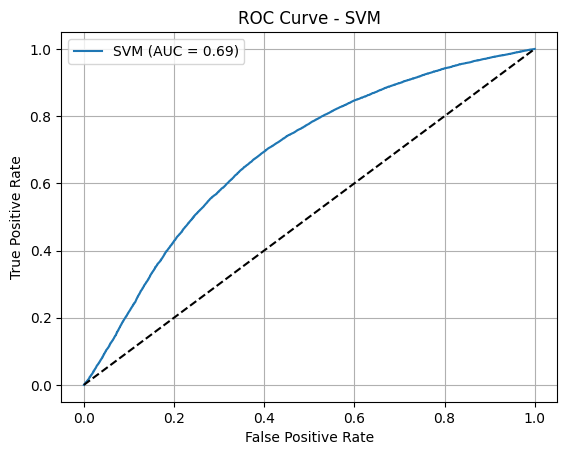

In [ ]:
svm_result = evaluate_model(  # SVM modelini değerlendirme fonksiyonuna gönder
    "SVM",  # Model adı

  #  SVC(probability=True),  # Sınıf olasılıklarını döndürebilen destek vektör makinesi
SVC(probability=False),  # Olasılık tahmini yapılmasın (hız için)
    {
        'clf__C': [1],              # Ceza parametresi için yalnızca 1 değeri denenir
        'clf__kernel': ['linear']   # Sadece lineer çekirdek kullanılır (hız için sadeleştirilmiş)
    },

    X_scaled,  # Ölçeklenmiş veri
    y_clean,   # Etiketler

    feature_k_values,  # k en iyi özellik seçimi için alternatifler

    outer_cv,  # Model test stratejisi
    inner_cv   # Parametre arama stratejisi
)



✅ KNN Sonuçları:
Accuracy: 0.6764, Precision: 0.6877, Recall: 0.7402, F1: 0.7130, AUC: 0.7345


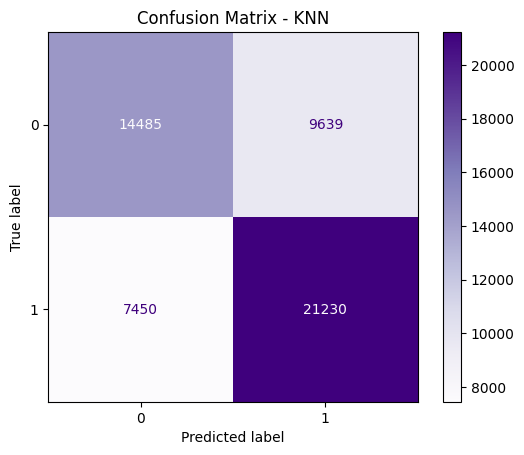

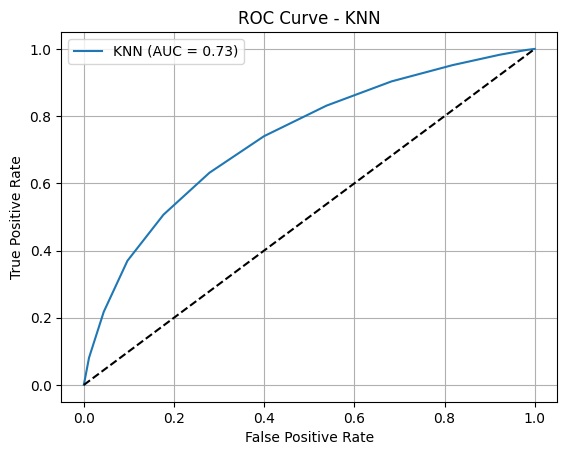

In [ ]:
knn_result = evaluate_model(  # KNN modelini değerlendirme fonksiyonuna gönder
    "KNN",  # Model adı (çıktılar ve grafik başlıkları için)

    KNeighborsClassifier(),  # Varsayılan KNN sınıflandırıcı

    {
        'clf__n_neighbors': list(range(3, 12, 2))  # Komşu sayısı için 3, 5, 7, 9, 11 değerleri denenir
    },

    X_scaled,  # Ölçeklenmiş ve temizlenmiş giriş verisi (özellikler)
    y_clean,   # Temizlenmiş hedef sınıf etiketleri (0 ve 1)

    feature_k_values,  # SelectKBest ile denenecek k değerleri (örneğin: [10, 15, 20])

    outer_cv,  # 5 katlı dış çapraz doğrulama (modelin test başarımını ölçer)
    inner_cv   # 3 katlı iç çapraz doğrulama (GridSearch için)
)


In [ ]:
mlp_result = evaluate_model(
    "MLP",
    MLPClassifier(max_iter=200),
    {
        'clf__hidden_layer_sizes': [(50,)],     # Sadece bir yapı deneniyor
        'clf__activation': ['relu']             # Sadece bir aktivasyon fonksiyonu
    },
    X_scaled, y_clean,
    feature_k_values,
    outer_cv, inner_cv
)

In [ ]:

xgboost_result = evaluate_model(
    "XGBoost",
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    {
        'clf__n_estimators': [100],
        'clf__max_depth': [3, 5],
        'clf__learning_rate': [0.1, 0.01]
    },
    X_scaled, y_clean,
    feature_k_values,
    outer_cv, inner_cv
)

In [ ]:

# Tüm sonuçları liste olarak birleştir
all_results = [knn_result, mlp_result, svm_result, xgboost_result]

# DataFrame’e çevir
results_df = pd.DataFrame(all_results)

# ROC-AUC skoruna göre sıralı tabloyu göster
results_df_sorted = results_df.sort_values(by="ROC-AUC", ascending=False)

# Görüntüle
print("📊 Karşılaştırmalı Model Performansları (ROC-AUC’ye göre sıralı):")
display(results_df_sorted)

📊 Karşılaştırmalı Model Performansları (ROC-AUC’ye göre sıralı):


,Model,Best k,Best Params,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Mean Test ROC-AUC,Std
3,XGBoost,20,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.713772,0.733446,0.743061,0.738222,0.786231,0.786231,0.004077
1,MLP,15,"{'clf__activation': 'relu', 'clf__hidden_layer...",0.712370,0.729706,0.747211,0.738354,0.784572,0.784947,0.004103
0,KNN,10,{'clf__n_neighbors': 11},0.676369,0.687745,0.740237,0.713026,0.734475,0.734488,0.002450
2,SVM,20,"{'clf__C': 1, 'clf__kernel': 'linear'}",0.650462,0.645598,0.790272,0.710646,0.686816,0.686852,0.005880


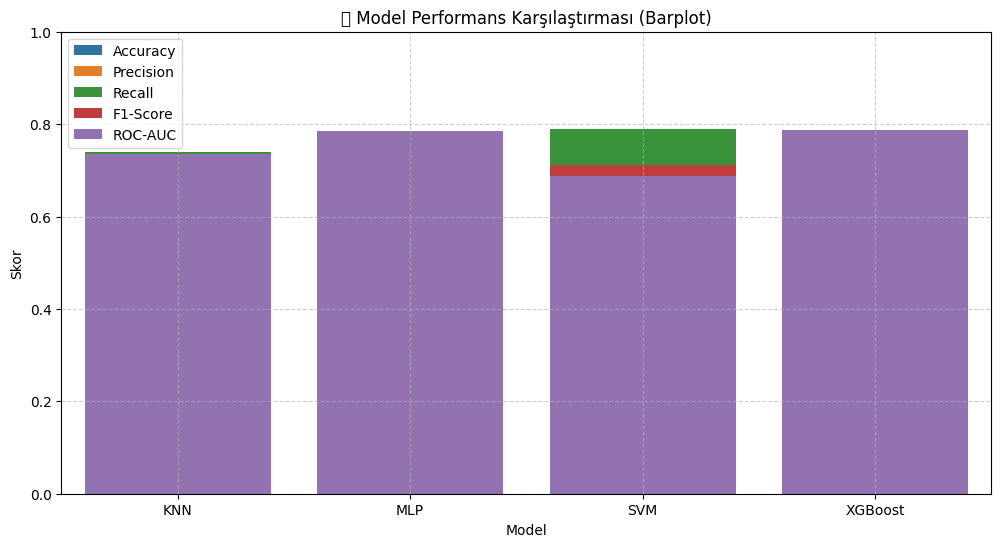

In [ ]:
###Barplot ile karşılaştırma (seçilen metrikler için)


import matplotlib.pyplot as plt
import seaborn as sns

# Görsel ayar
plt.figure(figsize=(12, 6))
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

# Bar plot: her metrik için ayrı barlar
for metric in metrics_to_plot:
    sns.barplot(x="Model", y=metric, data=results_df, label=metric)

plt.title("📊 Model Performans Karşılaştırması (Barplot)")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


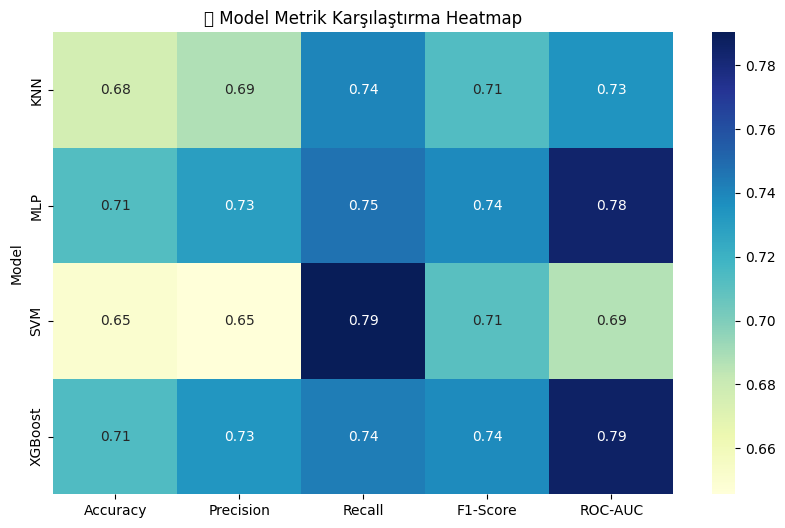

In [ ]:
### Heatmap (Metrik ısı haritası)

# ROC-AUC, Accuracy, F1 gibi sayısal metrikleri seç
heatmap_data = results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]]

# Isı haritası
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("🔍 Model Metrik Karşılaştırma Heatmap")
plt.show()


✅ SVM Sonuçları:
Accuracy: 0.6503, Precision: 0.6455, Recall: 0.7903, F1: 0.7106, AUC: 0.6868


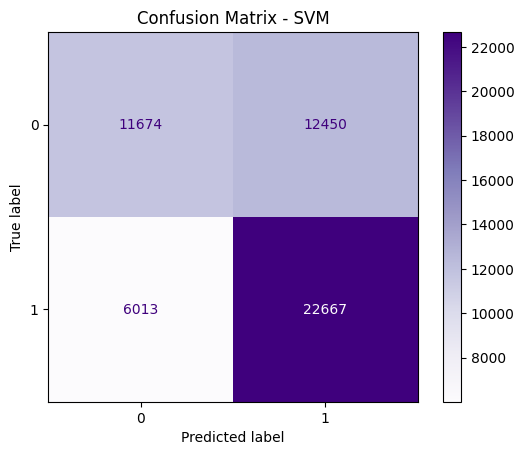

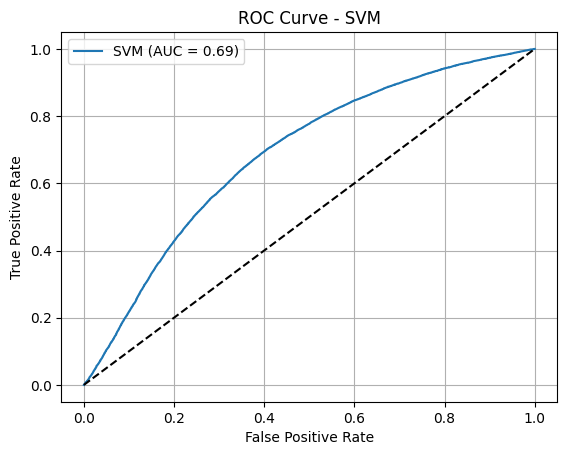

In [ ]:
svm_result = evaluate_model(  # SVM modelini değerlendirme fonksiyonuna gönder
    "SVM",  # Model adı

  #  SVC(probability=True),  # Sınıf olasılıklarını döndürebilen destek vektör makinesi
SVC(probability=False),  # Olasılık tahmini yapılmasın (hız için)
    {
        'clf__C': [0.1],              # Ceza parametresi için yalnızca 1 değeri denenir
        'clf__kernel': ['linear']   # Sadece lineer çekirdek kullanılır (hız için sadeleştirilmiş)
    },

    X_scaled,  # Ölçeklenmiş veri
    y_clean,   # Etiketler

    feature_k_values,  # k en iyi özellik seçimi için alternatifler

    outer_cv,  # Model test stratejisi
    inner_cv   # Parametre arama stratejisi
)